In [1]:
!pwd
import sys
sys.path.append('..')
from bumps.names import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import scipy.fft as fft
import molgroups as mol

/Users/alyssa/Documents/GitHub/molgroups/Diffraction


In [2]:
def getSLD(aArea, aSL, dimension, stepsize, normArea, bulknsld):
    aSLD = np.zeros(dimension).tolist()
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i]*stepsize) * aArea[i] / normArea + bulknsld * (1 - aArea[i]/normArea)
        else:
            aSLD[i] = bulknsld
    return aSLD

In [3]:
def computeFormFactor(lq, aSLD, dimension, stepsize, bulknsld, prefactor, dq):
    center = bilayer.fnGetCenter()
    center = center//stepsize
    canvas_center = dimension//2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1])*0.5
    symmetrized_bilayer -= bulknsld
    half_bilayer = symmetrized_bilayer[int(dimension/2):]

    # TODO: Make sure that lq and x are roughly comparable
    dct_dimension = 5000
    F = fft.dct(half_bilayer, n=dct_dimension)
    F = np.abs(F)
    x = np.array([np.pi/(2*dct_dimension*stepsize)*(2*i)*dq for i in range(dct_dimension)])

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, left=None, right=None, period=None)*prefactor

In [4]:
def setBilayer(startz, l_lipid, sigma, bulknsld, rel_pos, hg_thickness, methyl_sigma):
    bilayer.headgroup1.fnSet(hg_thickness, rel_pos)
    bilayer.headgroup2.fnSet(hg_thickness, rel_pos)
    bilayer.methyl_sigma = methyl_sigma
    bilayer.fnSet(sigma, bulknsld, startz, l_lipid, l_lipid, vf_bilayer=1)

In [5]:
def modelformfactor(lq, l_lipid, sigma, bulknsld, prefactor, dq, rel_pos, hg_thickness, methyl_sigma):
    setBilayer(startz, l_lipid, sigma, bulknsld, rel_pos, hg_thickness, methyl_sigma)
    normArea, aArea, aSL = bilayer.fnWriteProfile(np.zeros(dimension), np.zeros(dimension), dimension, stepsize, maxarea)
    aSLD = getSLD(aArea, aSL, dimension, stepsize, normArea, bulknsld)
    modelform = computeFormFactor(lq, aSLD, dimension, stepsize, bulknsld, prefactor, dq)
    return modelform

Global Variables

In [6]:
    maxarea = 100
    stepsize = 0.5
    dimension = 300
    startz = 50

Load Experimental Data

In [7]:
F2 = np.loadtxt("dopc.dat", skiprows=1)
F2 = np.abs(F2)
q_exp = F2[:,0]
form_exp = F2[:,1]
#constant error bar estimate of .05 Å
dform_exp = [0.05]*len(form_exp)

OSError: dopc.dat not found.

In [ ]:
bilayer = mol.BLM_quaternary()
na1, nh1, nm1, va1, vm1, vh1, lh1 = 7.5978E-03, 4.6150E-03, 5.0652E-04, 972.00, 98, 331.00, 9.56
bilayer.fnInit(va1, na1, vm1, nm1, vh1, nh1, lh1)

In [ ]:
l_lipid = 11.6
sigma = 2.0
bulknsld = 9.4114E-06
prefactor = 15000
dq = 1.
rel_pos = .5
methyl_sigma = 2

In [ ]:
M1 = Curve(modelformfactor, q_exp, form_exp, dform_exp, l_lipid=l_lipid, sigma=sigma, bulknsld=bulknsld,
           prefactor=prefactor, dq=dq, rel_pos=rel_pos, hg_thickness=lh1, methyl_sigma=methyl_sigma)

In [ ]:
M1.l_lipid.range(9, 13)
M1.sigma.range(1.0, 4.0)
M1.bulknsld.range(9e-6, 10e-6)
M1.prefactor.range(5000, 30000)
M1.dq.range(.9, 1.1)
M1.hg_thickness.range(8, 14)
M1.rel_pos.range(0, 1)
M1.methyl_sigma.range(0, 4)

Parameter(methyl_sigma)

In [ ]:
model = M1
problem = FitProblem(model)

In [ ]:
result = fit(problem, method='dream', samples=10, burn=100, steps=100, thin=1, alpha=0, outliers='none', trim = 'none')

# steps: 10, # draws: 800
Did not converge!


In [ ]:
from bumps.dream.stats import var_stats, format_vars, save_vars
print("final chisq", problem.chisq_str())
draw = result.state.draw(portion=1)
all_vstats = var_stats(draw)
print(format_vars(all_vstats))

final chisq 3.307(11)
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1             bulknsld 9.415(35)e-6 0.000009411 0.000009328 [0.00000941 0.00000942] [0.00000936 0.00000947]
 2                   dq 1.0007(49)  1.0000  1.0308 [  1.000   1.000] [  0.996   1.016]
 3         hg_thickness  9.560(12)  9.5600  9.5034 [  9.559   9.562] [  9.533   9.584]
 4              l_lipid 11.597(40)  11.600  11.397 [  11.60   11.60] [  11.48   11.67]
 5         methyl_sigma  1.990(48)   2.000   1.892 [   1.99    2.00] [   1.89    2.02]
 6            prefactor 15000.0(23) 15000.00 14999.51 [14998.9 15001.2] [14994.8 15005.1]
 7              rel_pos  0.511(38)   0.500   0.721 [   0.50    0.50] [   0.50    0.63]
 8                sigma  1.996(40)   2.000   1.593 [   2.00    2.00] [   1.85    2.02]


/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-packages/bumps/dream/varplot.py:240: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolormesh(x, y, z, vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-packages/bumps/dream/varplot.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers, height, maxlikelihood = array(bins).T
/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-packages/bumps/dream/varplot.py:240: Matp

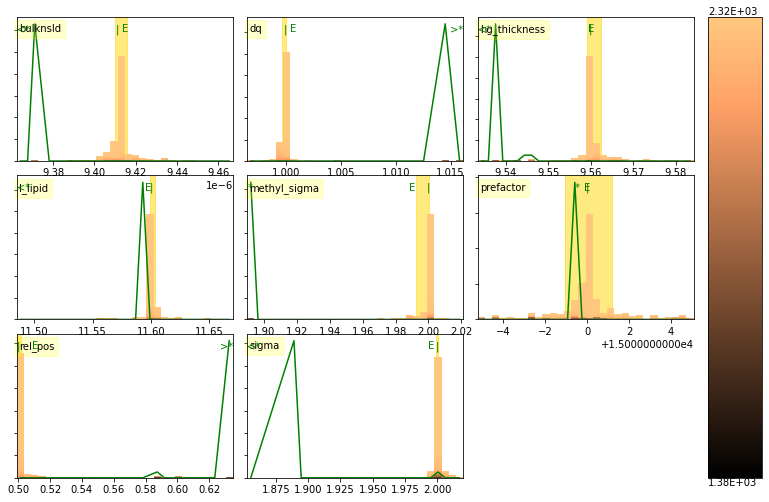

In [ ]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig, suptitle, rcParams
figure(figsize=varplot.var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0]//10000, 400), 30)
varplot.plot_vars(draw, all_vstats, nbins=nbins)

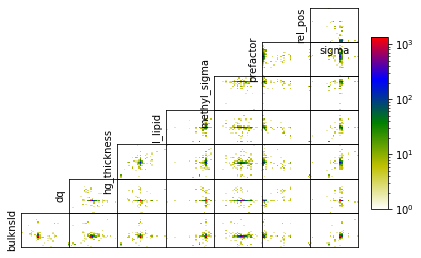

In [ ]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()

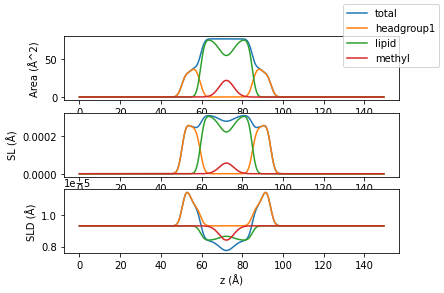

In [ ]:
import plot
bulknsld, dq, hg_thickness, l_lipid, methyl_sigma, prefactor, rel_pos, sigma = result.x
setBilayer(startz, l_lipid, sigma, bulknsld, rel_pos, hg_thickness, methyl_sigma)
plot.graphProfiles(bilayer, dimension, stepsize, maxarea, bulknsld, show=True, savefile=None)